dataset:


https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

Training Autoencoder...
Epoch [1/600], Loss: 0.1509
Epoch [2/600], Loss: 0.0943
Epoch [3/600], Loss: 0.0627
Epoch [4/600], Loss: 0.0427
Epoch [5/600], Loss: 0.0384
Epoch [6/600], Loss: 0.0364
Epoch [7/600], Loss: 0.0332
Epoch [8/600], Loss: 0.0301
Epoch [9/600], Loss: 0.0280
Epoch [10/600], Loss: 0.0274
Epoch [11/600], Loss: 0.0273
Epoch [12/600], Loss: 0.0265
Epoch [13/600], Loss: 0.0263
Epoch [14/600], Loss: 0.0255
Epoch [15/600], Loss: 0.0255
Epoch [16/600], Loss: 0.0248
Epoch [17/600], Loss: 0.0244
Epoch [18/600], Loss: 0.0238
Epoch [19/600], Loss: 0.0234
Epoch [20/600], Loss: 0.0234
Epoch [21/600], Loss: 0.0226
Epoch [22/600], Loss: 0.0222
Epoch [23/600], Loss: 0.0221
Epoch [24/600], Loss: 0.0217
Epoch [25/600], Loss: 0.0217
Epoch [26/600], Loss: 0.0213
Epoch [27/600], Loss: 0.0211
Epoch [28/600], Loss: 0.0208
Epoch [29/600], Loss: 0.0205
Epoch [30/600], Loss: 0.0203
Epoch [31/600], Loss: 0.0199
Epoch [32/600], Loss: 0.0198
Epoch [33/600], Loss: 0.0195
Epoch [34/600], Loss: 0.0194

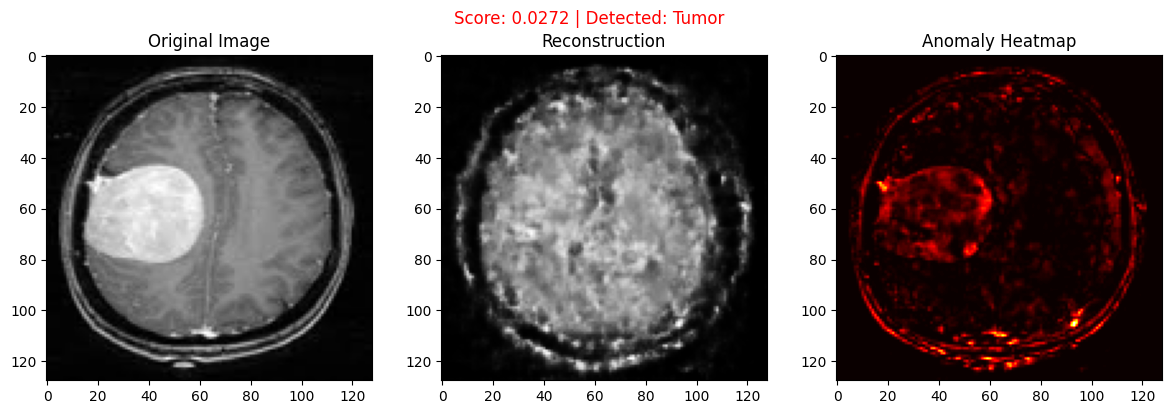

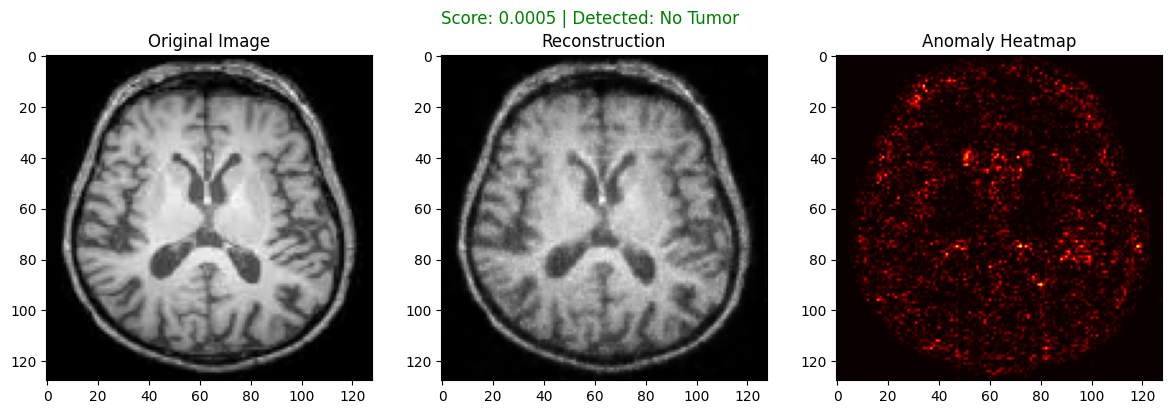

In [5]:
# Re-execute code after runtime reset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Configuration
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 600
LEARNING_RATE = 1e-3
DATA_DIR = "brain_tumor_dataset"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
class MRIDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = np.expand_dims(image, axis=0).astype(np.float32) / 255.0
        return torch.tensor(image), self.image_paths[idx]

# Improved Autoencoder with Bottleneck
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU()
        )
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 128 * 16 * 16),
            nn.ReLU(),
            nn.Unflatten(1, (128, 16, 16))
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x



# Load Data
def get_image_paths():
    healthy_paths = glob(os.path.join(DATA_DIR, "no", "*.jpg"))
    tumor_paths = glob(os.path.join(DATA_DIR, "yes", "*.jpg"))
    return healthy_paths, tumor_paths


# Train
def train_autoencoder(model, dataloader, optimizer, criterion):
    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(dataloader):.4f}")


# Classification
def classify_anomalies(model, image_paths, threshold):
    results = []
    model.eval()
    with torch.no_grad():
        for path in image_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype(np.float32) / 255.0
            input_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device)
            recon = model(input_tensor)
            error = F.mse_loss(recon, input_tensor, reduction='none')
            score = error.mean().item()
            pred = 1 if score > threshold else 0
            label = 1 if "yes" in path else 0
            results.append((os.path.basename(path), score, pred, label))
    return results


# Evaluate
def evaluate_results(results):
    y_true = [r[3] for r in results]
    y_pred = [r[2] for r in results]
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))


# Heatmap
def show_anomaly_heatmap(model, image_path, threshold=None):
    model.eval()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)).astype(np.float32) / 255.0
    input_tensor = torch.tensor(image_resized).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        recon = model(input_tensor)
        error_map = F.mse_loss(recon, input_tensor, reduction='none').squeeze().cpu().numpy()

    recon_np = recon.squeeze().cpu().numpy()
    input_np = input_tensor.squeeze().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(input_np, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Reconstruction")
    plt.imshow(recon_np, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Anomaly Heatmap")
    plt.imshow(error_map, cmap='hot')
    if threshold:
        anomaly_score = np.mean(error_map)
        plt.suptitle(f"Score: {anomaly_score:.4f} | Detected: {'Tumor' if anomaly_score > threshold else 'No Tumor'}",
                     color='red' if anomaly_score > threshold else 'green')
    plt.tight_layout()
    plt.show()


# Main
def main():
    healthy_paths, tumor_paths = get_image_paths()
    train_set = MRIDataset(healthy_paths)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    model = ConvAutoencoder().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    print("Training Autoencoder...")
    train_autoencoder(model, train_loader, optimizer, criterion)

    # Threshold calculation
    healthy_scores = []
    for img_path in healthy_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype(np.float32) / 255.0
        input_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            recon = model(input_tensor)
            error = F.mse_loss(recon, input_tensor, reduction='none')
            score = error.mean().item()
            healthy_scores.append(score)

    mean_score = np.mean(healthy_scores)
    std_score = np.std(healthy_scores)
    #threshold = mean_score + 2 * std_score
    threshold = mean_score + 1 * std_score

    print(f"Auto threshold: {threshold:.4f}")

    results = classify_anomalies(model, healthy_paths + tumor_paths, threshold)
    evaluate_results(results)

    show_anomaly_heatmap(model, tumor_paths[0], threshold)
    show_anomaly_heatmap(model, healthy_paths[0], threshold)


# Run
main()

